# Reverse time migration example on a 2D  acoustic model

## Set up environment.

In [1]:
from ipyparallel import Client
c = Client(profile='mpi')
dview = c[:]

with dview.sync_imports():
    import sys
    import numpy
    from examples.acoustic import demo_toolkit
    from examples.acoustic.Acoustic_codegen import Acoustic_cg

# Plotting modules.
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

importing sys on engine(s)
importing numpy on engine(s)
importing demo_toolkit from examples.acoustic on engine(s)
importing Acoustic_cg from examples.acoustic.Acoustic_codegen on engine(s)


## Load synthetic velocity model.

In [2]:
demo = demo_toolkit.small_phantoms2D()
model = demo.get_true_model()

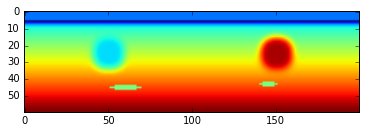

In [3]:
# Plot true velocity
fig1 = plt.figure()
#l = plt.imshow(numpy.transpose(model.vp), vmin=1.5, vmax=4, aspect=1)
l = plt.imshow(model.vp)
plt.show()

## Create "initial guess" by smoothening the synthetic velocity model.

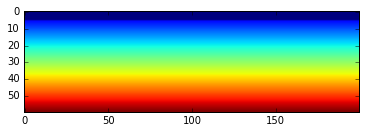

In [4]:
model0 = demo.get_initial_model()

# Plot smooth velocity
fig2 = plt.figure()
# l = plt.imshow(numpy.transpose(model0.vp), vmin=1.5, vmax=4, aspect=1)
l = plt.imshow(model0.vp)
plt.show()

## Example of a shot record

In [5]:
# %load_ext snakeviz

GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/4559ebdeb72456b6b7bc2aa51450efc2fbb5157c.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/ef461fd83cc43aa77244d3b82cedaee03069f9a4.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/80b6c7e38903a9be0836857bec9cd89538112353.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/dbdacb0f1fda4f37761d66bfcc6c3ffd796ca091.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/8a590ea297fb923979cf8c416ed2232e95f25cbe.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/be3c59aecbd1ee76fa2a0202b6f6a7e2b6d4ff2e.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/acbd41ada9658878b0054c6193e82516dc995091.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/e4f9e74c4c23a5d6a4000

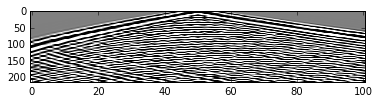

In [ ]:
# %%snakeviz
data, rec = demo.get_shot(50)

# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model0, data, t_order=2, s_order=10)

# Execute acoustic forward model.
rec0, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

# Show the shot record at the receivers.
fig3 = plt.figure()
l = plt.imshow(rec0, vmin=-.1, vmax=.1, aspect=.1, cmap=cm.gray)
plt.show()

## RTM loop

In [ ]:
# %%snakeviz
def grad_shot(i):
    demo = demo_toolkit.small_phantoms2D()

    model0 = demo.get_initial_model()
    data, rec = demo.get_shot(i)

    Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)

    # Return gradient
    return Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

grads = dview.map(grad_shot, range(demo.nsrc))

grad = sum(grads)

fig4 = plt.figure()
l = plt.imshow(numpy.diff(numpy.diff(numpy.transpose(grad[40:-40,40:-40]),1,0),1), 
               vmin=-100, vmax=100, aspect=1, cmap=cm.gray)
plt.show()